### Solver API scratchbook

In [1]:
# %matplotlib widget
# import ipywidgets as widgets
import matplotlib.pyplot as plt
import time
import re

from nuMSM_solver.solvers import *
from nuMSM_solver.quadrature import TrapezoidalQuadrature, GaussianQuadrature
from nuMSM_solver.rates import Rates_Fortran, Rates_Jurai
from nuMSM_solver.common import zT, Tz

from leptotools.leptoAPI import LeptoToolsSolver

In [2]:
# Optimal phases
delta_opt = np.pi
eta_opt = (3.0*np.pi)/2.0
rew_opt = np.pi/4.0

# Model params
mp = ModelParams(M=2.0, dM=1e-9, Imw=4.0, Rew=rew_opt, delta=delta_opt, eta=eta_opt)

# Metaparams
H = 1
ode_pars = {'atol': 1e-15, 'rtol': 1e-6}
TF = Tsph
cutoff = 1e5

In [3]:
# Set up quadrature scheme and rates
n_kc = 10
kc_max = 10

# Hide annoying warning
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    quad = GaussianQuadrature(n_kc, 0, kc_max, qscheme="legendre")
    rates = Rates_Jurai(mp, H, quad.kc_list(), tot=False)

In [4]:
# # Set up trapezoidal quadrature and fortran rates
kc_list = [0.3, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
fortran_quad = TrapezoidalQuadrature(kc_list)
fortran_rates = Rates_Fortran(mp, H)



In [5]:
# # Solve equations with QuadratureSolver
quad_solver = QuadratureSolver(rates, quad,
                         model_params=mp, TF=TF, H=H, cutoff=cutoff, eig_cutoff=False,
                         method="LSODA", ode_pars=ode_pars, source_term=True)

start = time.time()
quad_solver.solve()
end = time.time()
quad_bau = (28./79.) * quad_solver.get_final_lepton_asymmetry()
print("QuadratureSolver; time (solve): {}, BAU = {}".format(end - start, quad_bau))

The solver successfully reached the end of the integration interval.
True
QuadratureSolver; time (solve): 158.3601713180542, BAU = nan


In [6]:
# Solve equations with LeptoToolsSolver
lepto_solver = LeptoToolsSolver(model_params=mp, TF=TF, quadrature=quad, H=H, cutoff=cutoff, 
                          method="Radau", ode_pars=ode_pars)

start = time.time()
lepto_solver.solve()
end = time.time()
lepto_bau = (28./79.) * lepto_solver.get_final_lepton_asymmetry()
print("LeptoToolsSolver; time (solve): {}, BAU = {}".format(end - start, lepto_bau))

/home/admin/SciCodes/leptogenesis-tools/leptotools/rates.py:460: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(dA,l,L,args=(k0,k,m1,m2),points=poles)[0]
/home/admin/SciCodes/leptogenesis-tools/leptotools/rates.py:466: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval an

LeptoToolsSolver; time (solve): 14.009354591369629, BAU = -4.634838001188026e-09


In [7]:
# Solve equations with AveragedSolver
avg_solver = AveragedSolver(rates_interface=rates, model_params=mp, TF=TF, H=H, cutoff=cutoff, eig_cutoff=False,
                           method="Radau", ode_pars=ode_pars, source_term=True)

start = time.time()
avg_solver.solve()
end = time.time()
avg_bau = (28./79.) * avg_solver.get_final_lepton_asymmetry()
print("AveragedSolver; time (solve): {}, BAU = {}".format(end - start, avg_bau))

/home/admin/SciCodes/nuMSM/nuMSM_solver/common.py:57: RuntimeWarning: overflow encountered in double_scalars
  return -1*((T*E_k)/Mpl)*np.exp(E_k/T)/((1 + np.exp(E_k/T))**2)


AveragedSolver; time (solve): 126.458979845047, BAU = -3.5200484646738126e-09


In [23]:
# # Solve equations with AveragedSolver + fortran rates
avg_solver_ft = AveragedSolver(rates_interface=fortran_rates, model_params=mp, TF=TF, H=H, cutoff=cutoff, eig_cutoff=False,
                           method="LSODA", ode_pars=ode_pars, source_term=True)

start = time.time()
avg_solver_ft.solve()
end = time.time()
avg_bau_ft = (28./79.) * avg_solver_ft.get_final_lepton_asymmetry()
print("AveragedSolver; time (solve): {}, BAU = {}".format(end - start, avg_bau_ft))

/home/admin/SciCodes/nuMSM/nuMSM_solver/common.py:57: RuntimeWarning: overflow encountered in double_scalars
  return -1*((T*E_k)/Mpl)*np.exp(E_k/T)/((1 + np.exp(E_k/T))**2)


AveragedSolver; time (solve): 69.45651006698608, BAU = 4.503221486506397e-09


In [9]:
# # Solve equations with QuadratureSolver + fortran rates
quad_solver_ft = QuadratureSolver(fortran_rates, fortran_quad,
                         model_params=mp, TF=TF, H=H, cutoff=cutoff, eig_cutoff=False,
                         method="LSODA", ode_pars=ode_pars, source_term=True)

start = time.time()
quad_solver_ft.solve()
end = time.time()
quad_bau_ft = (28./79.) * quad_solver_ft.get_final_lepton_asymmetry()
print("QuadratureSolver; time (solve): {}, BAU = {}".format(end - start, quad_bau_ft))

The solver successfully reached the end of the integration interval.
True
QuadratureSolver; time (solve): 652.3109705448151, BAU = 2.21549355984388e-08


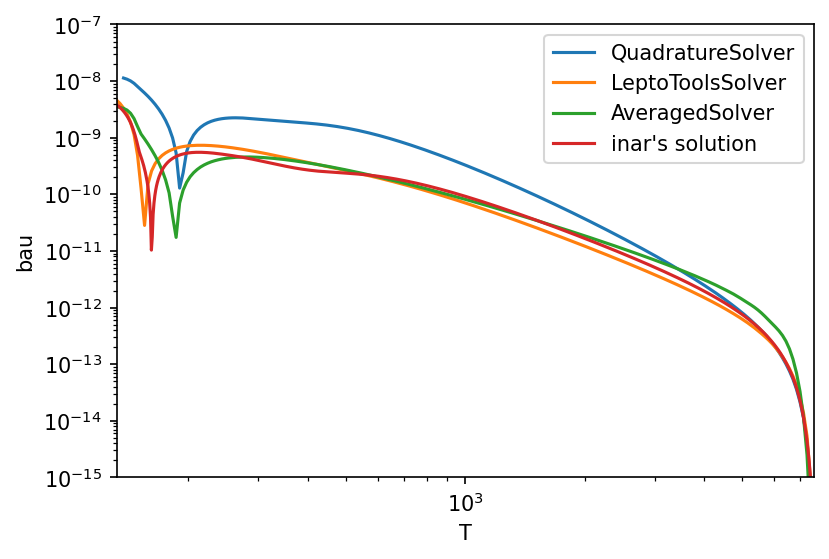

In [30]:
# Plot BAU generation
inar_data = np.loadtxt("sol10modes09_50.csv", delimiter=",")

# Clean up fortran data
def fixfloat(f):
    if f.find('E') == -1:
        split = f.split('-')
        split[-2] += "E"
        return "-".join(split)
    else:
        return f

fortran_data = np.array([[float(fixfloat(f)) for f in l.strip().split("    ")] for l in open("LA_Evo_OrgH.dat").readlines()])

fig = plt.figure(dpi=150)
fig.clear()
ax = fig.add_subplot(111)
plt.xlabel("T")
plt.ylabel("bau")
plt.xscale("log")
plt.yscale("log")
ax.set_ylim((1e-15, 1e-7))
ax.set_xlim((min(quad_solver.get_Tlist()),max(quad_solver.get_Tlist())))
plt.plot(quad_solver.get_Tlist(), (28./79.) * np.abs(np.array(quad_solver.get_total_lepton_asymmetry())),
        label="QuadratureSolver")
# plt.plot(quad_solver_ft.get_Tlist(), (28./79.) * np.abs(np.array(quad_solver_ft.get_total_lepton_asymmetry())),
#         label="QuadratureSolver (fortran rates)")
plt.plot(lepto_solver.get_Tlist(), (28./79.) * np.abs(np.array(lepto_solver.get_total_lepton_asymmetry())),
        label="LeptoToolsSolver")
plt.plot(avg_solver.get_Tlist(), (28./79.) * np.abs(np.array(avg_solver.get_total_lepton_asymmetry())),
        label="AveragedSolver")
# plt.plot(avg_solver_ft.get_Tlist(), (28./79.) * np.abs(np.array(avg_solver_ft.get_total_lepton_asymmetry())),
#         label="AveragedSolver (fortran rates)")
plt.plot(inar_data[:,0],(28./79.) * np.abs(inar_data[:,1] + inar_data[:,2] + inar_data[:,3]), label="inar's solution")
# plt.plot(fortran_data[:,0],(28./79.) * np.abs(fortran_data[:,1] + fortran_data[:,2] + fortran_data[:,3]), label="fortran (averaged)")
plt.legend()
